In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data shapes
Sqh:  (31, 236, 200, 2, 2)
Vel:  (31, 236, 200, 2)
Coordinates shapes
XX: (31, 236, 200) Range [3.22966, 455.701] um
YY: (31, 236, 200) Range [3.22657, 536.891] um
TT: (31, 236, 200) Range [-10, 20] min
Flattened shapes
(1463200, 1) (1463200, 1) (1463200, 1)
(1463200, 2, 2) (1463200, 2)
Training shapes
(100000, 1) (100000, 1) (100000, 1)
(100000, 2, 2) (100000, 2)


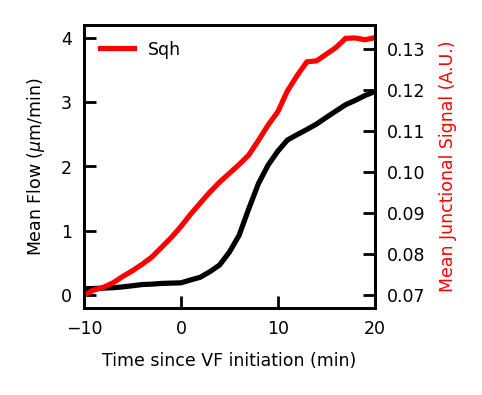

In [44]:
plt.rcParams['font.size'] = 5
loaddir = '/project/vitelli/jonathan/REDO_fruitfly/test_data'
t = np.load(os.path.join(loaddir, 'time.npy'), mmap_mode='r')
t_min = -10
t_max = 25
mask = np.logical_and(t >= t_min, t <= t_max)
t = t[mask]
sqh = np.load(os.path.join(loaddir, 'myosin.npy'), mmap_mode='r')[mask]
sqh = sqh.reshape([sqh.shape[0], 2, 2, *sqh.shape[-2:]])
vel = np.load(os.path.join(loaddir, 'velocity.npy'), mmap_mode='r')[mask]
y = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
x = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')

    
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)), 
         color='red', label='Sqh')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 20])
#ax2.set_yticks([80, 100, 120])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal (A.U.)', color='red')
ax.set_xlabel('Time since VF initiation (min)')

print('Data shapes')

sqh = sqh.transpose(0, 3, 4, 1, 2)
vel = vel.transpose(0, 2, 3, 1)

print('Sqh: ', sqh.shape)
print('Vel: ', vel.shape)

nAP = x.shape[1]
nDV = y.shape[0]
nTP = t.shape[0]

XX = np.broadcast_to(x[None], (nTP, nDV, nAP))
YY = np.broadcast_to(y[None], (nTP, nDV, nAP))
TT = np.broadcast_to(t[:, None, None], (nTP, nDV, nAP))

print('Coordinates shapes')
print(f'XX: {XX.shape} Range [{XX.min():g}, {XX.max():g}] um')
print(f'YY: {YY.shape} Range [{YY.min():g}, {YY.max():g}] um')
print(f'TT: {TT.shape} Range [{TT.min():g}, {TT.max():g}] min')

lower_bound = np.array([TT.min(), YY.min(), XX.min()])
upper_bound = np.array([TT.max(), YY.max(), XX.max()])

t = TT.flatten()[:, None]
y = YY.flatten()[:, None]
x = XX.flatten()[:, None]

sqh_train = sqh.reshape([-1, *sqh.shape[3:]])
vel_train = vel.reshape([-1, *vel.shape[3:]])

print('Flattened shapes')
print(t.shape, y.shape, x.shape)
print(sqh_train.shape, vel_train.shape)

N_train = 100000
idx = np.random.choice(nAP*nDV*nTP, N_train, replace=False)

x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]

sqh_train = sqh_train[idx, :]
vel_train = vel_train[idx, :]
print('Training shapes')
print(t_train.shape, y_train.shape, x_train.shape)
print(sqh_train.shape, vel_train.shape)

# MAKE SURE TO RE-RUN PINNS WITH MORE PHYSICS-RESIDUAL POINTS AND FEWER MSE RESIDUAL POINTS

Iteration 0		grad^2 v + 0.001 grad(div(v) - grad p = -3.394 div(m)



Text(0, 0.5, 'Pressure')

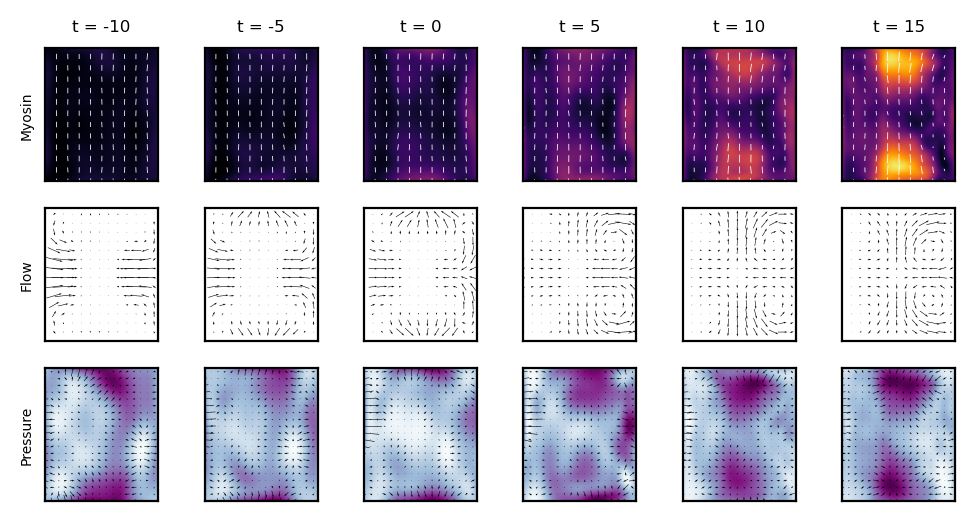

In [59]:
from utils.plot_utils import *
from run_CompressibleStokesPINN import *
import torch

device = torch.device('cpu')
model = BulkCompressibleStokesPINN(
    t_train, y_train, x_train,
    sqh_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './'
beta = 1e5
model.load_state_dict(torch.load(
    os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu'))
with torch.no_grad():
    model.print()
    sqh, vel, pre = model(
        torch.from_numpy(t).float().to(device),
        torch.from_numpy(y).float().to(device),
        torch.from_numpy(x).float().to(device),
    )
    sqh = sqh.cpu().numpy()
    vel = vel.cpu().numpy()
    pre = pre.cpu().numpy()
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
    sqh_pred = sqh.reshape([nTP, nDV, nAP, 2, 2]).transpose(0, 3, 4, 1, 2)
    vel_pred = vel.reshape([nTP, nDV, nAP, 2]).transpose(0, 3, 1, 2)
    pre_pred = pre.reshape([nTP, nDV, nAP])
    
np.save('PINN_pressure', pre_pred)
    
N = 6
fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
dt = min(10, sqh_pred.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    p = pre_pred[i*dt]
    plot_tensor2D(ax[0, i], sqh_pred[i*dt], vmin=0.06, vmax=0.25, cmap='inferno')
    plot_vector2D(ax[1, i], vel_pred[i*dt], skip=16)
    color_2D(ax[2, i], p-np.min(p), cmap='BuPu')
    grad_p = np.stack([
        np.gradient(p, axis=-2),
        np.gradient(p, axis=-1),
    ])
    plot_vector2D(ax[2, i], grad_p, skip=12)
    
    for j in range(3):
        ax[j, i].set_ylim([dv_min, dv_max])
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Flow')
ax[2, 0].set_ylabel('Pressure')

In [22]:
#Make sure data is left-right symmetrized

m0 = np.load('../../test_data/myosin.npy', mmap_mode='r')
v0 = np.load('../../test_data/velocity.npy', mmap_mode='r')
c0 = np.load('../../test_data/cadherin.npy', mmap_mode='r')


def symmetrize(f):
    f_lr = f[..., ::-1, :].copy()
    if f.shape[1] == 4:
        f_lr[:, 1:3] *= -1
    elif f.shape[1] == 2:
        f_lr[:, 0] *= -1
    f = 0.5 * (f + f_lr)
    return f

m0 = symmetrize(m0)
v0 = symmetrize(v0)
c0 = symmetrize(c0)

np.save('../../test_data/myosin.npy', m0)
np.save('../../test_data/cadherin.npy', c0)
np.save('../../test_data/velocity.npy', v0)

0.0
0.0


tensor([ 18.5225, 483.6993, 416.7434]) tensor([-9.7617,  3.9752,  3.4594])


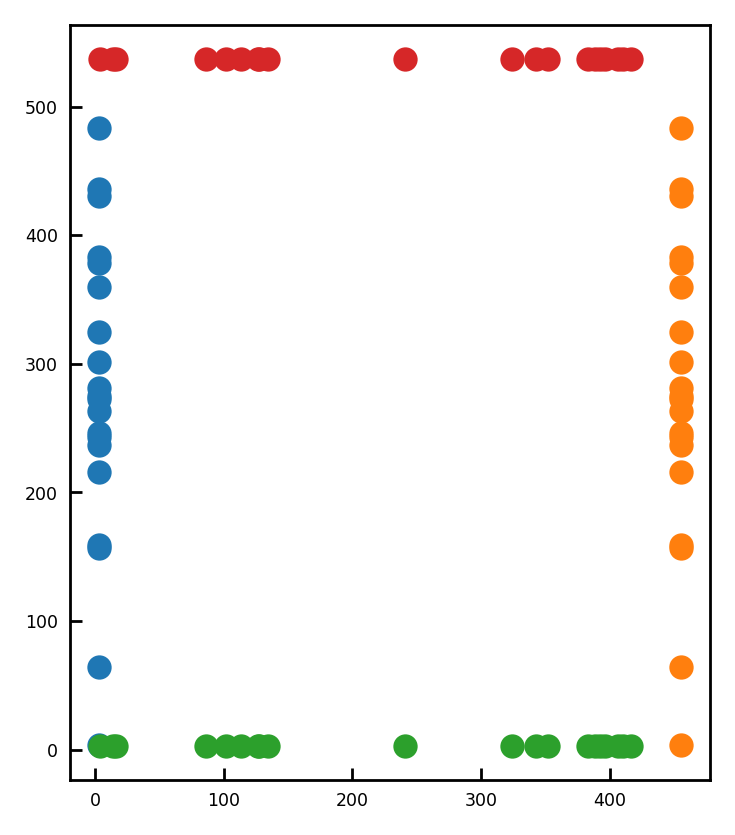

In [41]:
Nb = 20
bTDA = torch.rand([Nb, 3]) * (model.ub - model.lb) + model.lb

boundary_t = bTDA[:, 0].repeat(Nb*4)
boundary_y = torch.zeros([Nb, Nb * 4])
boundary_x = torch.zeros([Nb, Nb * 4])

boundary_y[:, :Nb] = bTDA[:, 1]
boundary_x[:, :Nb] = model.lb[2]

boundary_y[:, Nb:2*Nb] = bTDA[:, 1]
boundary_x[:, Nb:2*Nb] = model.ub[2]

boundary_y[:, 2*Nb:3*Nb] = model.lb[1]
boundary_x[:, 2*Nb:3*Nb] = bTDA[:, 2]

boundary_y[:, 3*Nb:4*Nb] = model.ub[1]
boundary_x[:, 3*Nb:4*Nb] = bTDA[:, 2]

plt.figure(dpi=250)
plt.scatter(boundary_x[0, :Nb], boundary_y[0, :Nb])
plt.scatter(boundary_x[0, Nb:2*Nb], boundary_y[0, Nb:2*Nb])
plt.scatter(boundary_x[0, 2*Nb:3*Nb], boundary_y[0, 2*Nb:3*Nb])
plt.scatter(boundary_x[0, 3*Nb:4*Nb], boundary_y[0, 3*Nb:4*Nb])
plt.gca().set_aspect('equal')

In [30]:
boundary_t = torch.linspace(model.lb[0], model.lb[1], Nb)
print(boundary_t.shape, boundary_x.shape, boundary_y.shape)

torch.Size([40]) torch.Size([160]) torch.Size([160])
